In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
booking= pd.read_csv('/kaggle/input/hotel-booking-cancellation-prediction/booking.csv')
booking.drop(['Booking_ID'], inplace=True, axis=1)
booking.index += 1

print(booking.shape)
booking.head()

(36285, 16)


,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
1,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
2,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
3,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
4,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
5,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


In [3]:
booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 1 to 36285
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   number of adults          36285 non-null  int64  
 1   number of children        36285 non-null  int64  
 2   number of weekend nights  36285 non-null  int64  
 3   number of week nights     36285 non-null  int64  
 4   type of meal              36285 non-null  object 
 5   car parking space         36285 non-null  int64  
 6   room type                 36285 non-null  object 
 7   lead time                 36285 non-null  int64  
 8   market segment type       36285 non-null  object 
 9   repeated                  36285 non-null  int64  
 10  P-C                       36285 non-null  int64  
 11  P-not-C                   36285 non-null  int64  
 12  average price             36285 non-null  float64
 13  special requests          36285 non-null  int64  
 14  date o

In [4]:
booking.isnull().sum().sort_values(ascending=False)
##print null values

number of adults            0
number of children          0
number of weekend nights    0
number of week nights       0
type of meal                0
car parking space           0
room type                   0
lead time                   0
market segment type         0
repeated                    0
P-C                         0
P-not-C                     0
average price               0
special requests            0
date of reservation         0
booking status              0
dtype: int64

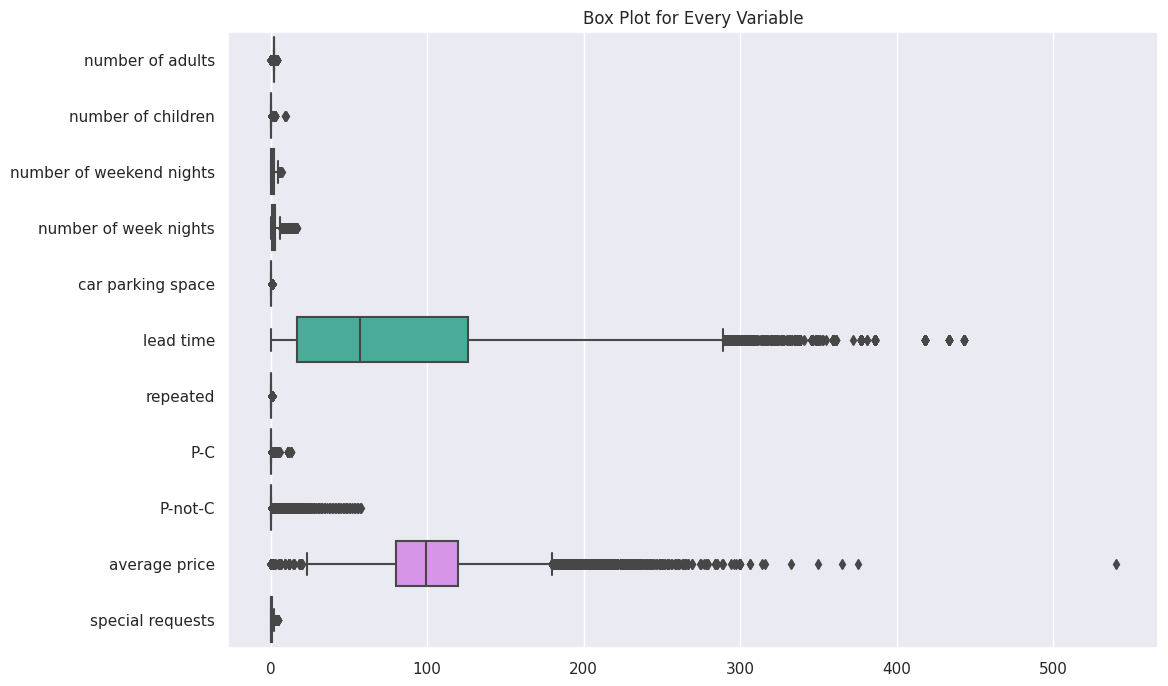

(36285, 16)


In [5]:
#detecting outlier columns
plt.figure(figsize=(12, 8))
sns.set(style="darkgrid")
sns.boxplot(data=booking, orient="h")
plt.title("Box Plot for Every Variable")
plt.show()
print(booking.shape)

In [6]:
#remove outliers using 1.5*IQR method
outlier_cols=['average price', 'lead time']
for col in outlier_cols:
    if booking[col].dtype in ['int64', 'float64']:
        q1= booking[col].quantile(0.25)
        q3= booking[col].quantile(0.75)
        iqr= q3-q1
        lower_bound= q1- 1.5*iqr
        upper_bound= q3+ 1.5*iqr

        booking= booking[(booking[col]>=lower_bound) & (booking[col]<=upper_bound)]

In [7]:
#encoding categorical variable: 'target'
booking['booking status']= booking['booking status'].replace('Canceled', 1)
booking['booking status']= booking['booking status'].replace('Not_Canceled', 0)

booking.head()

,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
1,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,0
2,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,0
3,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,1
4,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,1
5,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,1


In [8]:
booking = booking[~booking["date of reservation"].str.contains("-")]
booking["date of reservation"] = pd.to_datetime(booking["date of reservation"])
#remove dates with dashes & convert to time object

booking["day"] = booking["date of reservation"].dt.day
booking["month"] = booking["date of reservation"].dt.month
booking["year"] = booking["date of reservation"].dt.year

# Drop the original datetime column
booking = booking.drop(columns=["date of reservation"])
booking.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33438 entries, 1 to 36285
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   number of adults          33438 non-null  int64  
 1   number of children        33438 non-null  int64  
 2   number of weekend nights  33438 non-null  int64  
 3   number of week nights     33438 non-null  int64  
 4   type of meal              33438 non-null  object 
 5   car parking space         33438 non-null  int64  
 6   room type                 33438 non-null  object 
 7   lead time                 33438 non-null  int64  
 8   market segment type       33438 non-null  object 
 9   repeated                  33438 non-null  int64  
 10  P-C                       33438 non-null  int64  
 11  P-not-C                   33438 non-null  int64  
 12  average price             33438 non-null  float64
 13  special requests          33438 non-null  int64  
 14  booking sta

In [9]:
booking["average price"] = booking["average price"].round().astype(int)
#round to int
#one hot encoding to variables of dtype 'object'
object_columns= booking.select_dtypes(include=['object']).columns
booking= pd.get_dummies(booking, columns= object_columns)
booking= booking.replace({True:1, False:0})
print(booking.info())
booking.head()


<class 'pandas.core.frame.DataFrame'>
Index: 33438 entries, 1 to 36285
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   number of adults                   33438 non-null  int64
 1   number of children                 33438 non-null  int64
 2   number of weekend nights           33438 non-null  int64
 3   number of week nights              33438 non-null  int64
 4   car parking space                  33438 non-null  int64
 5   lead time                          33438 non-null  int64
 6   repeated                           33438 non-null  int64
 7   P-C                                33438 non-null  int64
 8   P-not-C                            33438 non-null  int64
 9   average price                      33438 non-null  int64
 10  special requests                   33438 non-null  int64
 11  booking status                     33438 non-null  int64
 12  day                    

,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,...,room type_Room_Type 3,room type_Room_Type 4,room type_Room_Type 5,room type_Room_Type 6,room type_Room_Type 7,market segment type_Aviation,market segment type_Complementary,market segment type_Corporate,market segment type_Offline,market segment type_Online
1,1,1,2,5,0,224,0,0,0,88,...,0,0,0,0,0,0,0,0,1,0
2,1,0,1,3,0,5,0,0,0,107,...,0,0,0,0,0,0,0,0,0,1
3,2,1,1,3,0,1,0,0,0,50,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,2,0,211,0,0,0,100,...,0,0,0,0,0,0,0,0,0,1
5,1,0,1,2,0,48,0,0,0,77,...,0,0,0,0,0,0,0,0,0,1


In [10]:
#feature selection
features= booking.drop(['booking status'], axis=1)
target= booking['booking status']
k_best= SelectKBest(score_func=f_classif, k=10)

X= k_best.fit_transform(features, target)
y= target

#indices of the selected features
selected_features_indices = k_best.get_support(indices=True)

#scores associated with each feature
feature_scores = k_best.scores_

#list of tuples containing feature names and scores
feature_info = list(zip(features.columns, feature_scores))

# Sort features based on scores
sorted_feature_info = sorted(feature_info, key=lambda x: x[1], reverse=True)

for feature_name, feature_score in sorted_feature_info[:10]:
    print(f"{feature_name}: {feature_score:.2f}")

lead time: 6933.78
special requests: 2168.84
year: 974.02
average price: 632.02
market segment type_Online: 606.17
market segment type_Corporate: 423.34
repeated: 348.43
number of week nights: 254.00
market segment type_Offline: 221.38
car parking space: 218.93


In [11]:
selected_features_df = features.iloc[:, selected_features_indices]
selected_features_df.head()

,number of week nights,car parking space,lead time,repeated,average price,special requests,year,market segment type_Corporate,market segment type_Offline,market segment type_Online
1,5,0,224,0,88,0,2015,0,1,0
2,3,0,5,0,107,1,2018,0,0,1
3,3,0,1,0,50,0,2018,0,0,1
4,2,0,211,0,100,1,2017,0,0,1
5,2,0,48,0,77,0,2018,0,0,1


In [12]:
#split data
X_train, X_test, y_train, y_test = train_test_split(
    X, target, test_size=0.2, random_state=42
)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

scores = {} #map model to its scores

Best Parameters: {'C': 100, 'penalty': 'l2'}
Best Score: 0.7975700934579439
Accuracy: 0.79
Confusion Matrix: 
[[4139  482]
 [ 903 1164]]


<Axes: >

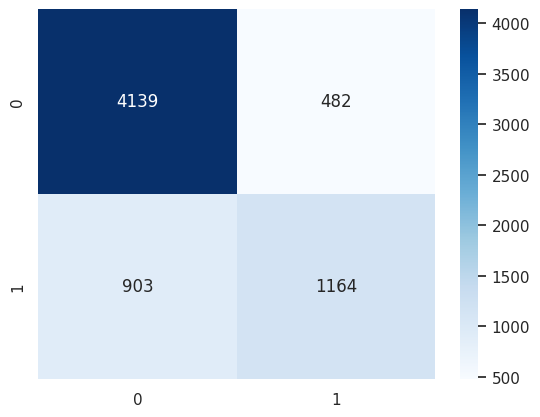

In [13]:
log_reg = LogisticRegression()

params = {"C": [0.01, 0.1, 1, 10, 100], "penalty": ["l1", "l2"]}

grid_search = GridSearchCV(log_reg, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

best_log_reg = grid_search.best_estimator_ #retreives best model

y_pred = best_log_reg.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
scores["Logistic Regression"] = accuracy_score(y_test, y_pred)

print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt=".0f")

Best Parameters: {'n_neighbors': 2}
Accuracy: 0.83
Confusion Matrix: 
[[4379  242]
 [ 908 1159]]


<Axes: >

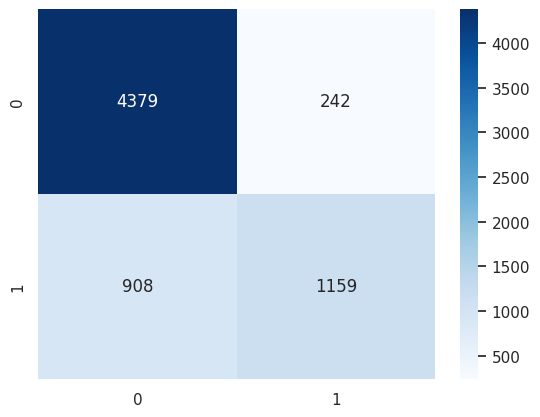

In [14]:
knn = KNeighborsClassifier()

params = {"n_neighbors": np.arange(1, 10)}

grid_search = GridSearchCV(knn, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

best_knn = grid_search.best_estimator_

y_pred = best_knn.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
scores["KNN"] = accuracy_score(y_test, y_pred)

print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt=".0f")

Best Parameters: {'criterion': 'entropy', 'max_depth': 15}
Accuracy: 0.86
Confusion Matrix: 
[[4215  406]
 [ 522 1545]]


<Axes: >

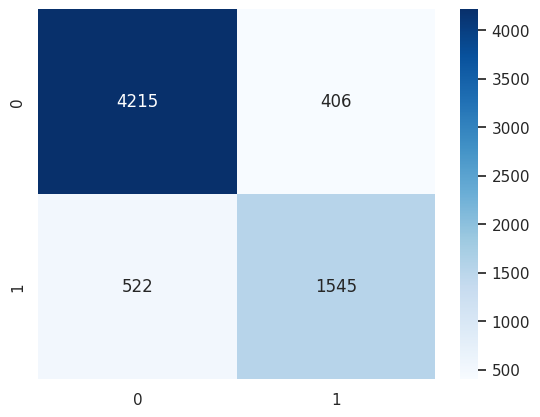

In [15]:
dt = DecisionTreeClassifier()

params = {"max_depth": np.arange(0, 30, 5), "criterion": ["gini", "entropy"]}
#max levels in tree:30 with step:5

grid_search = GridSearchCV(dt, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

best_dt = grid_search.best_estimator_

y_pred = best_dt.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
scores["Decision Tree"] = accuracy_score(y_test, y_pred)

print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt=".0f")

Accuracy: 0.88
Confusion Matrix: 
[[4306  315]
 [ 489 1578]]


<Axes: >

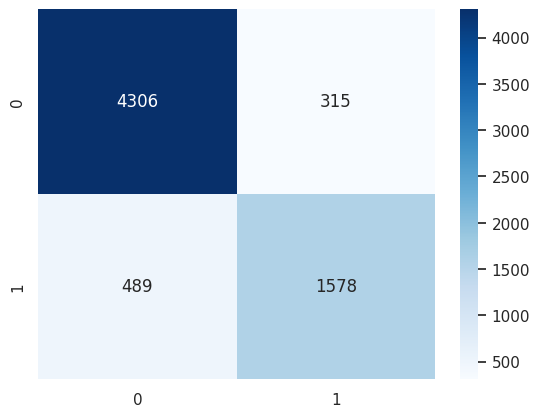

In [16]:
rf = RandomForestClassifier(max_depth=20, n_estimators=50)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
scores["Random Forest"] = accuracy_score(y_test, y_pred)

print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt=".0f")

In [17]:
#comparison of models used
for model,score in scores.items():
    print(f"{model}: {score:.4f}")

Logistic Regression: 0.7929
KNN: 0.8281
Decision Tree: 0.8612
Random Forest: 0.8798
